# Chevron curve for qudit (0-1)

The $x$-axis is the time, or the amplitude. We'll choose amplitude (actually Martinis chose time I guess, not really sure). It's easier to think of rabi amplitude as a dimensionless number, than to stick to a fixed amplitude (with no plan of doing it) and reasoning using the complicated normalization system of IBM (dt = 2/9 nanoseconds and all of that).

The $y$-axis is the detuning. We'll not really know the real frequency $\omega_{01}=(E_{|1\rangle}-E_{|0\rangle})/\hbar$. We'll just have to add detuning $\delta\omega$ to the estimated frequency $\tilde{\omega}$. In the benefits of hindsint, this will tell you exactly what to expect from the population of the qubit in the event of an unknown detuning, i.e. what's the state vector in the Bloch sphere?

## Measure of $\omega_{01}$

In [37]:
from qiskit import IBMQ
from qiskit import pulse, schedule                  
from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

import numpy as np 
import matplotlib.pyplot as plt

#IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
qubit = 0

%config InlineBackend.figure_formats = ['svg']

pi = np.pi

In [11]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def baseline_remove(values):
    return np.array(values) - np.mean(values)

In [12]:
backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
lcm = 16
scale_factor = 1e-7
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 

Sampling time: 0.2222222222222222 ns


In [13]:
omega_01_est = backend_defaults.qubit_freq_est[qubit]

min_freq = omega_01_est-40*1e6
max_freq = omega_01_est+40*1e6
freq_probe = np.linspace(min_freq, max_freq, 99)

freq = Parameter('freq')

with pulse.build(backend=backend) as freq_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=160, sigma=40, amp=0.05), drive_chan)
    
sweep_gate = Gate("FREQ_PROBE", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)
qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), freq_sweep_sched, [freq])

exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in freq_probe]

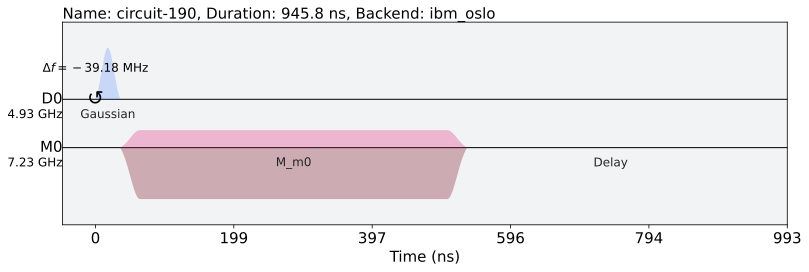

In [14]:
sweep_schedule = schedule(exp_sweep_circs[1], backend)
sweep_schedule.draw(backend=backend)

In [203]:
num_shots = 2048

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots)

print(job.job_id())
job_monitor(job)

63f0bf1880412578cba28248
Job Status: job has successfully run


In [15]:
job = backend.retrieve_job('63f0bf1880412578cba28248')
frequency_sweep_results = job.result() 
freq_probe_GHz = freq_probe/1e9

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    
fit_params, y_fit = fit_function(freq_probe_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [6, 4.925, 1, -2] # initial parameters for curve_fit
                                )

fit_params

array([ -0.68890984,   4.9250731 ,  -0.02449212, -15.74287203])

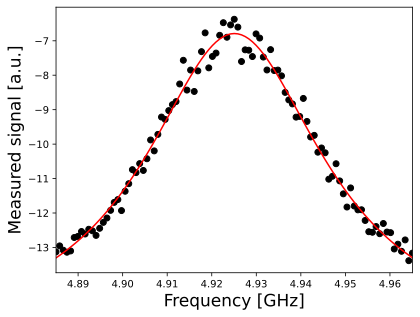

We've updated our qubit frequency estimate from 4.92505 GHz to 4.925073 GHz.


In [17]:
plt.scatter(freq_probe_GHz, np.real(sweep_values), color='black')
plt.plot(freq_probe_GHz, y_fit, color='red')
plt.xlim([freq_probe_GHz[0], freq_probe_GHz[-1]])
plt.xlabel("Frequency [GHz]", size=17)
plt.ylabel("Measured signal [a.u.]", size=17)
plt.show()

A, omega_01_est, B, C = fit_params
omega_01_est = omega_01_est*1e9 # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / 1e9, 5)} GHz to {round(omega_01_est/1e9, 6)} GHz.")

## Rabi oscillation on (01)

In [19]:
f01 = omega_01_est

In [121]:
drive_amps = np.linspace(0, 1, 99)

drive_amp = Parameter('drive_amp')

with pulse.build(backend=backend) as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=112, sigma=112/4, amp=drive_amp), drive_chan)
    
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

In [122]:
num_shots = 2**14

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots)

print(job.job_id())
job_monitor(job)

63f4b088617197284f89704a
Job Status: job has successfully run


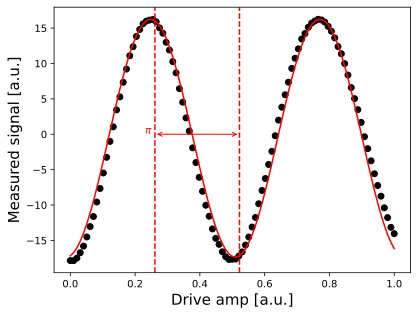

In [149]:
job = backend.retrieve_job('63f4b088617197284f89704a')

rabi_results = job.result(timeout=120)

rabi_values = []
for i in range(99):
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [20, 0, 0.35, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] 

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

## Measure of $\omega_{12}$

In [150]:
x_amp_01 = abs(drive_period/2)

In [80]:
anhar = backend_properties.qubits[qubit][3].value*1e9

omega_12_est = f01 + anhar

min_freq = omega_12_est-40*1e6
max_freq = omega_12_est+40*1e6
freq_probe = np.linspace(min_freq, max_freq, 99)

freq = Parameter('freq')

with pulse.build(backend=backend) as freq_sweep_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=160, sigma=40, amp=x_amp_01), drive_chan)
    pulse.set_frequency(freq, drive_chan)
    pulse.play(pulse.Gaussian(duration=160, sigma=40, amp=0.05), drive_chan)
    
sweep_gate = Gate("FREQ_PROBE", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)
qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), freq_sweep_sched, [freq])

exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in freq_probe]

In [267]:
num_shots = 2048

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots)

print(job.job_id())
job_monitor(job)

63f314fb2a88b6e1a6e25daa
Job Status: job has successfully run


In [27]:
job = backend.retrieve_job('63f314fb2a88b6e1a6e25daa')

frequency_sweep_results = job.result() 
freq_probe_GHz = freq_probe/1e9

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    res = frequency_sweep_results.get_memory(i)*scale_factor
    sweep_values.append(res[qubit])
    
fit_params, y_fit = fit_function(freq_probe_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [-20, 4.6, 1, -2] 
                                )

fit_params

array([ 0.11772566,  4.58083534, -0.02774389, 21.63982378])

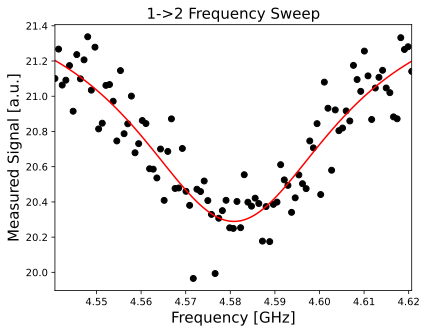

Our updated estimate for the 1->2 transition frequency is 4.5808353 GHz from 4.5806772.


In [29]:
plt.scatter(freq_probe_GHz, sweep_values, color='black')
plt.plot(freq_probe_GHz, y_fit, color='red')
plt.xlim([freq_probe_GHz[0], freq_probe_GHz[-1]])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("1->2 Frequency Sweep", fontsize=15)
plt.show()

f12 = fit_params[1]*1e9
print(f"Our updated estimate for the 1->2 transition frequency is "
      f"{round(f12/1e9, 7)} GHz from {round(omega_12_est/1e9, 7)}.")

## Rabi oscillation on (12)

In [151]:
drive_amps = np.linspace(0, 1, 99)

drive_amp = Parameter('drive_amp')

with pulse.build(backend=backend) as rabi_sched:
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=112, sigma=112/4, amp=x_amp_01), drive_chan)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=112, sigma=112/4, amp=drive_amp), drive_chan)
    
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

In [126]:
num_shots = 2**14

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots)

print(job.job_id())
job_monitor(job)

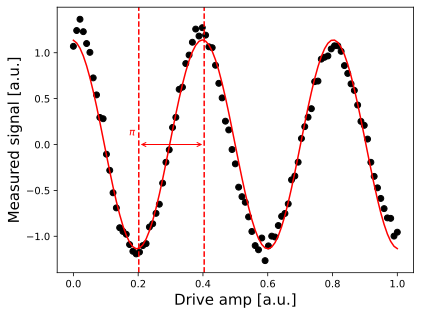

In [152]:
job = backend.retrieve_job('63f4b74083564e34d991fea4')
rabi_results = job.result(timeout=120)

rabi_values = []
for i in range(99):
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [20, 0, 0.35, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] 

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')
plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [153]:
x_amp_12 = abs(drive_period/2)

## Discriminator

In [154]:
def r01(theta, phi):
    with pulse.build(backend=backend) as r01:
        drive_chan = pulse.drive_channel(qubit)
        pulse.delay(48, drive_chan)
        pulse.set_frequency(f01, drive_chan)
        with pulse.phase_offset(phi, drive_chan):
            pulse.play(pulse.Gaussian(112, theta*x_amp_01/np.pi, 112/4), drive_chan)
    return r01

def r12(theta, phi):
    with pulse.build(backend=backend) as r12:
        drive_chan = pulse.drive_channel(qubit)
        pulse.delay(48, drive_chan)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(phi, drive_chan):
            pulse.play(pulse.Gaussian(112, theta*x_amp_12/np.pi, 112/4), drive_chan)
    return r12

g01 = Gate("r01", 1, [])
g12 = Gate("r12", 1, [])

In [155]:
prep0 = QuantumCircuit(1,1)
prep0.measure(0, 0)

prep1 = QuantumCircuit(1,1)
prep1.append(g01, [0])
prep1.measure(0, 0)
prep1.add_calibration(g01, (0,), r01(pi,0), [])

prep2 = QuantumCircuit(1,1)
prep2.append(g01, [0])
prep2.append(g12, [0])
prep2.measure(0, 0)
prep2.add_calibration(g01, (0,), r01(pi,0), [])
prep2.add_calibration(g12, (0,), r12(pi,0), [])

package = [prep0, prep1, prep2]

## Two SX

In [156]:
test_sx01 = QuantumCircuit(1,1)
test_sx01.append(g01, [0])
test_sx01.append(g01, [0])
test_sx01.measure(0,0)
test_sx01.add_calibration(g01, (0,), r01(pi/2,0), [])

test_sx12 = QuantumCircuit(1,1)
test_sx12.append(g01, [0])
test_sx12.append(g12, [0])
test_sx12.append(g12, [0])
test_sx12.measure(0,0)
test_sx12.add_calibration(g01, (0,), r01(pi,0), [])
test_sx12.add_calibration(g12, (0,), r12(pi/2,0), [])

package = [prep0, prep1, prep2, test_sx01, test_sx12]

In [157]:
num_shots = 2**14

job = backend.run(package, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)
print(job.job_id())
job_monitor(job)

63f500b9f0238433862d1a55
Job Status: job has successfully run


In [158]:
test = DataAnalysis(experiment=job, num_shots=2**14)
test.retrieve_data(average=False)
test.lda()
test.count_pop()
test.error_mitiq()

In [159]:
test.raw_counted

[[0.9752197265625, 0.00799560546875, 0.01678466796875],
 [0.01959228515625, 0.96881103515625, 0.0115966796875],
 [0.01666259765625, 0.02984619140625, 0.9534912109375],
 [0.0238037109375, 0.88885498046875, 0.08734130859375],
 [0.0198974609375, 0.914794921875, 0.0653076171875]]

In [160]:
test.mitiq_data

array([[1.00000000e+00, 5.55111512e-17, 1.66533454e-16],
       [0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [4.45299004e-03, 9.15329602e-01, 8.02174081e-02],
       [8.68744773e-04, 9.42301108e-01, 5.68301474e-02]])

In [118]:
dt_128_raw, dt_128_mitiq

([[0.93377685546875, 0.00994873046875, 0.0562744140625],
  [0.02020263671875, 0.9627685546875, 0.01702880859375],
  [0.01654052734375, 0.03302001953125, 0.950439453125],
  [0.02252197265625, 0.86932373046875, 0.108154296875],
  [0.02001953125, 0.51910400390625, 0.46087646484375]],
 array([[1.00000000e+00, 1.66533454e-16, 5.55111512e-17],
        [1.11022302e-16, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00],
        [2.54500941e-03, 8.99991505e-01, 9.74634851e-02],
        [1.89961013e-03, 5.22763270e-01, 4.75337120e-01]]))

In [119]:
dt_160_raw, dt_160_mitiq

([[0.9093017578125, 0.013427734375, 0.0772705078125],
  [0.01422119140625, 0.96392822265625, 0.0218505859375],
  [0.01043701171875, 0.0294189453125, 0.96014404296875],
  [0.01654052734375, 0.863525390625, 0.11993408203125],
  [0.01348876953125, 0.29150390625, 0.69500732421875]],
 array([[1.00000000e+00, 5.55111512e-17, 0.00000000e+00],
        [1.66533454e-16, 1.00000000e+00, 0.00000000e+00],
        [1.11022302e-16, 1.66533454e-16, 1.00000000e+00],
        [2.56366136e-03, 8.92946680e-01, 1.04489659e-01],
        [1.86228797e-03, 2.80698203e-01, 7.17439509e-01]]))

In [120]:
dt_144_raw, dt_144_mitiq

([[0.9334716796875, 0.0130615234375, 0.053466796875],
  [0.02008056640625, 0.96478271484375, 0.01513671875],
  [0.01593017578125, 0.02996826171875, 0.9541015625],
  [0.0224609375, 0.91644287109375, 0.06109619140625],
  [0.02032470703125, 0.07830810546875, 0.9013671875]],
 array([[1.00000000e+00, 0.00000000e+00, 1.66533454e-16],
        [1.11022302e-16, 1.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 1.11022302e-16, 1.00000000e+00],
        [2.45443464e-03, 9.48675370e-01, 4.88701957e-02],
        [4.11405362e-03, 5.18920583e-02, 9.43993888e-01]]))

## Measure of $\omega_{23}$

In [54]:
f01

4925073097.710591

In [55]:
f12

4580835337.961713

In [56]:
f12-f01

-344237759.7488785

In [57]:
anhar

-344395877.1022938

In [59]:
(4.6944-4.9692)*1e6

-274799.99999999994

In [60]:
dt

2.2222222222222221e-10

In [66]:
(94*dt)/1e-9

20.888888888888886

In [65]:
110-16

94